# 1. IMPORT

In [2]:
#필요한 모듈을 import 합니다.
from numba import cuda

#이후 초기화 작업을 진행해줍니다.
device = cuda.get_current_device()
device.reset()

In [3]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [4]:
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    LoraConfig,
    PeftType,
    PrefixTuningConfig,
    PromptEncoderConfig,
    PeftModel, 
    PeftConfig,
)

peft_type = PeftType.LORA
peft_config = LoraConfig(task_type="SEQ_CLS",  r=8, lora_alpha=16, lora_dropout=0.1)

/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [5]:
from pytorchtools import EarlyStopping

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import random
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.optim import AdamW

import matplotlib as mpl
import matplotlib.pyplot as plt

from transformers import logging
logging.set_verbosity_error()
import warnings
warnings.filterwarnings(action='ignore')


In [7]:
device = torch.device('cuda')if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [8]:
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


# 하이퍼파라미터 설정

In [9]:
class config():
    def __init__(self):
        
        self.source_len=128
        self.epochs = 10
        self.learning_rate=0.00007
        self.batch_size=16
        self.shuffle = True
        self.seed=200
        self.num_labels=10
        self.data_path= '/home/work/CL/dataset/healthcare/healthcare5000.pickle'
        self.model_path = 'klue/roberta-large'
        # self.modelsave_path = r'C:\Users\user\OneDrive - KookminUNIV\바탕 화면\추가사전학습\Fine_tuning'
        # self.loss_path = r'C:\Users\user\OneDrive - KookminUNIV\바탕 화면\추가사전학습\Fine_tuning'
cfg = config()

# 랜덤시드 고정

In [10]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.bachends.cudnn.bechmark = True
    
    seed_everything(cfg.seed) #seed 고정

# 데이터 로드

In [11]:
# trainset.to_pickle('/home/work/CL/dataset/healthcare/healthcare_train.pickle')
# testset.to_pickle('/home/work/CL/dataset/healthcare/healthcare_test.pickle')
# valset.to_pickle('/home/work/CL/dataset/healthcare/healthcare_val.pickle')

trainset = pd.read_pickle('/home/work/CL/dataset/healthcare/healthcare_train.pickle')
testset = pd.read_pickle('/home/work/CL/dataset/healthcare/healthcare_test.pickle')
valset = pd.read_pickle('/home/work/CL/dataset/healthcare/healthcare_val.pickle')

In [12]:
for i in range(20):
    
    save_path = f"/home/work/CL/dataset/healthcare/16_asc{i+1}_combined.csv"
    globals()['trainset{}'.format(i+1)]= pd.read_csv(save_path)

In [13]:
trainset1

,clean_text,cos_dis,수도라벨
0,나병환자의 피부도말 검사의 염색법과 판독법에 대하여 고찰한다,0.292617,8
1,기존 유모차 또는 휠체어를 계단 에스컬레이터 및 경사로에서 안전하게 사용할 수 있도...,0.312076,5
2,전라남도 중고등학생들의 우울 정도와 자살에 대한 실태를 파악하고 어떠한 요소가 영향...,0.293319,8
3,및 유전자조작생쥐를 이용한 면역관용파괴 및 항암효과분석,0.307755,8
4,기존의 물리치료 장비는 냉각치료 기능이 없거나 별도의 냉각치료 장비를 구비하여 사용,0.316436,9
...,...,...,...
2939,주관기관 메디아나\n 개발\n 진단 기능의 측정 모듈 개발\n 실시간 진단 기능\n...,0.795272,9
2940,보급형 질량분석 진단기기 시제품 제작 기술 개발 \n 아래 사양을 만족하는 질량분석...,0.813591,9
2941,일회용 내시경 시스템 시제품 제작\n 및 채널을 구비한 벤딩 경비 내시경 시제품 제...,0.804985,9
2942,제품의 모듈화표준화를 통한 비용 절감과 사용자의 다양한 니즈를 충족시키고 사용자 중...,0.791470,5


In [14]:
trainset2

,clean_text,cos_dis,수도라벨
0,조직재생공학연구소는 중점연구소사업을통해손상된뼈치아신경이라는타겟조직을완벽히재생하기위한...,0.323545,7
1,조현병은 정신과 의사가 치료하는 질환 중에서 가장 이해하기 어려우면서도 비극적인 병...,0.317963,8
2,및 유전자조작생쥐를 이용한 면역관용파괴 및 항암효과분석,0.307755,8
3,이 신생혈관형성에 미치는 효과 및 관련 기전 규명,0.298206,6
4,기존 유모차 또는 휠체어를 계단 에스컬레이터 및 경사로에서 안전하게 사용할 수 있도...,0.312076,5
...,...,...,...
2939,현장진료를 위한 융합 지능형 휴대용 초음파 영상 시스템 요소 기술 개발\n 지능형 ...,0.794468,9
2940,피부충진 조성물인 조직수복용 재료의 연구개발을 통한 고부가가치화 실현 클린룸 시설과...,0.788493,5
2941,다양한 감염성 병원균의 신속 정확한 진단을 위한 프로브를 개발하고 이들을 이용한 통...,0.795100,6
2942,제품의 모듈화표준화를 통한 비용 절감과 사용자의 다양한 니즈를 충족시키고 사용자 중...,0.791470,5


# 토크나이저와 모델 정의

In [15]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup, set_seed

model = AutoModelForSequenceClassification.from_pretrained(cfg.model_path, num_labels=cfg.num_labels, output_hidden_states=False).cuda()
tokenizer = AutoTokenizer.from_pretrained(cfg.model_path)

model.resize_token_embeddings(len(tokenizer))
model

model_state_dict = torch.load("/home/work/CL/final_ictmodel/ict5epoch.pt", map_location=device)
model.load_state_dict(model_state_dict)

model = get_peft_model(model, peft_config).to(device)

model.print_trainable_parameters()
model


trainable params: 2,906,132 || all params: 338,512,916 || trainable%: 0.8584995911943283


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(32000, 1024, padding_idx=1)
          (position_embeddings): Embedding(514, 1024, padding_idx=1)
          (token_type_embeddings): Embedding(1, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0): RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): Linear(
                    in_features=1024, out_features=1024, bias=True
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (d

# 커스텀 데이터셋

In [16]:
class CustomDataset(Dataset):
    
    def __init__(self, data, labels, tokenizer, source_len) :
    # 내가 필요한 것들을 가져와서 선처리
        self.data = data.copy()
        self.labels = labels.copy()
        self.tokenizer = tokenizer
        self.source_len = source_len
    
    def __getitem__(self, index) :
    # 데이터 셋에서 한 개의 데이터를 가져오는 함수 정의
    
        text = self.data[index]
        inputs = self.tokenizer(text,max_length=self.source_len,padding='max_length',truncation=True, return_tensors='pt')
        # inputs = self.tokenizer.batch_encode_plus([text], max_length= self.source_len, truncation=True, padding='max_length',return_tensors='pt')
        label = self.labels[index]
        
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
        token_type_ids = inputs['token_type_ids'].squeeze()
        
        
        
    
        # input_ids = inputs['input_ids'][0]
        # attention_mask = inputs['attention_mask'][0]
        # token_type_ids = inputs['token_type_ids'][0]
        
        # return input_ids, attention_mask, token_type_ids, label
        
        inputs_dict = {
            'input_ids' : input_ids.to(device, dtype = torch.long),
            'attention_mask' : attention_mask.to(device, dtype = torch.long),
            'token_type_ids': token_type_ids.to(device, dtype = torch.long),
        }
        label = torch.tensor(label).to(device, dtype = torch.long)
        
        
        return inputs_dict, label
    
    def __len__(self) :
    # 데이터 셋의 길이
        return len(self.data)    

In [17]:
import pandas as pd

dataframes = []  # 데이터프레임 리스트 초기화

for i in range(1, 21):
    trainset = globals()[f"trainset{i}"]  # 동적으로 변수명을 활용하여 데이터프레임 가져오기
    dataframes.append(trainset)  # 데이터프레임 리스트에 추가

In [18]:
# 데이터프레임을 데이터셋으로 변환
datasets = []
for trainset in dataframes:
    dataset = CustomDataset(data=list([str(i) for i in trainset['clean_text'].values.copy()].copy()),
                            labels=list(trainset['수도라벨'].copy()),
                            tokenizer=tokenizer,
                            source_len=cfg.source_len)
    datasets.append(dataset)

# 데이터로더 생성
batch_size = 16
data_loaders = []
for dataset in datasets:
    data_loader = DataLoader(dataset, batch_size=cfg.batch_size, shuffle=False,num_workers=0)
    data_loaders.append(data_loader)
len(data_loaders)
# # 데이터로더 사용 예시
# for data_loader in data_loaders:
#     for batch in data_loader:
#         inputs_dict, label = batch
#         print(inputs_dict)
#         print(label)

20

In [19]:
# train_data = CustomDataset(data=list([str(i) for i in trainset['clean_text'].values.copy()].copy()),
#                            labels= list(trainset['수도라벨'].copy()),
#                            tokenizer= tokenizer,
#                            source_len= cfg.source_len)

val_data = CustomDataset(data=list([str(i) for i in valset['clean_text'].values.copy()].copy()),
                           labels= list(valset['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)


test_data = CustomDataset(data=list([str(i) for i in testset['clean_text'].values.copy()].copy()),
                           labels= list(testset['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)

# train_loader = DataLoader(train_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)
val_loader = DataLoader(val_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)
test_loader = DataLoader(test_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)


# Train, val 정의

In [20]:
def train(epoch, model, optimizer, loader):
    
    model.train()
    total_loss, total_accuracy = 0,0
    nb_train_steps = 0
    for _,(inputs, labels) in enumerate(loader, 0): 
        #enumerate는 인덱스까지 반환하는 함수(데이터, 스타트번호=0)
        outputs = model(**inputs, labels = labels)
        loss = outputs.loss
        

        pred = [logit.argmax().cpu().detach().item() for logit in outputs.logits]
        true = [label for label in labels.cpu().numpy()]
        acc = accuracy_score(true,pred)
        

        if _%32 ==0 : #만약 인덱스가 10이 되면
            print(f'Epoch : {epoch+1}, train_{_}_step_loss : {loss.item()}')
            psuedo_pred = [logit.argmax().item() for logit in outputs.logits]
            psuedo_acc = np.sum(np.array(labels.to('cpu'))==np.array(psuedo_pred))/len(labels)
            print(f'{epoch+1}_{_}_step_정확도 :{psuedo_acc}')
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
        total_accuracy += acc
        nb_train_steps += 1
    

    
    avg_loss = total_loss/len(loader)
    avg_acc = total_accuracy/nb_train_steps
    t_test_avg_acc = total_accuracy/len(loader)
    print(f'Epoch:{epoch+1}, train_{_}_stepLoss:{avg_loss}')
    print(f'Epoch:{epoch+1}, train_{_}_stepacc:{avg_acc}')
    print(f'Epoch:{epoch+1}, train_{_}_stepacc:{t_test_avg_acc}')
    loss_dic['train_loss'].append(avg_loss)
    loss_dic['train_acc'].append(avg_acc)

In [21]:
def validate(epoch, model, loader):
   
    model.eval()
    eval_loss, eval_accuracy = 0,0
    nb_eval_steps = 0
    with torch.no_grad():
        for _,(inputs, labels) in enumerate(loader, 0): 
        #enumerate는 인덱스까지 반환하는 함수(데이터, 스타트번호=0)
            outputs = model(**inputs, labels = labels)
            loss = outputs.loss
            eval_loss += loss.item()

            pred = [logit.argmax().cpu().detach().item() for logit in outputs.logits]
            true = [label for label in labels.cpu().numpy()]
            acc = accuracy_score(true,pred)
            eval_accuracy += acc
            nb_eval_steps +=1
            if _%32 ==0 : #만약 인덱스가 10이 되면
                print(f'Epoch : {epoch+1}, val_{_}_step_loss : {loss.item()}')
                predicted_class_id = [logit.argmax().item() for logit in outputs.logits]
                psuedo_acc = np.sum(np.array(labels.to('cpu'))==np.array(predicted_class_id))/len(labels)
                print(f'{epoch+1}_{_}_step_정확도 :{psuedo_acc}')
                
                
    e_avg_loss = eval_loss/len(loader)
    e_avg_acc = eval_accuracy/nb_eval_steps
    e_test_avg_acc = eval_accuracy/len(loader)
    print(f'Epoch:{epoch+1}, val_{_}_stepLoss:{e_avg_loss}')
    print(f'Epoch:{epoch+1}, val_{_}_stepacc:{e_avg_acc}')
    print(f'Epoch:{epoch+1}, val_{_}_stepacc:{e_test_avg_acc}')

    loss_dic['validation_loss'].append(e_avg_loss)
    loss_dic['val_acc'].append(e_avg_acc)                
    loss_dic['epoch'].append(epoch+1)

    early_stopping(e_avg_loss, model)
    return e_avg_loss, e_test_avg_acc
    




In [22]:

def infer(model, loader):
    
    model.eval()
    test_loss, test_accuracy = 0,0
    result_dic = {'prediction':[], 'label':[]}
    with torch.no_grad():
        for _,(inputs, labels) in tqdm(enumerate(loader, 0)): 
        #enumerate는 인덱스까지 반환하는 함수(데이터, 스타트번호=0)
            outputs = model(**inputs, labels = labels)
            loss = outputs.loss
            test_loss += loss.item()

            pred = [logit.argmax().cpu().detach().item() for logit in outputs.logits]
            true = [label for label in labels.cpu().numpy()]
            result_dic['prediction'].append(pred)
            result_dic['label'].append(true)                

            acc = accuracy_score(true,pred)
            test_accuracy += acc
        
            
                
    t_avg_loss = test_loss/len(loader)
    t_avg_acc = test_accuracy/len(loader)
    print(f'test_{_}_stepLoss:{t_avg_loss}')
    print(f'test_{_}_stepacc:{t_avg_acc}')

    
    return t_avg_loss, t_avg_acc
    
        

# RUN

In [23]:
optimizer = torch.optim.AdamW(params = model.parameters(), lr=0.00007)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.* (len(data_loader) * cfg.epochs),
    num_training_steps=(len(data_loader) * cfg.epochs),
)

In [23]:
loss_dic = {'epoch':[],'train_loss':[], 'validation_loss':[],'train_acc':[],'val_acc':[]}
early_stopping = EarlyStopping(patience = 3, verbose = True)


for epoch in tqdm(range(0,cfg.epochs)):
    train(epoch, model, optimizer, data_loaders[epoch])
    lr_scheduler.step()

    validate(epoch, model, val_loader)
    
    # if early_stopping.early_stop:
    #     break
    torch.save(model, f'/home/work/CL/final_healthmodel/lora_asc_{epoch+1}epoch.pt')

    
    

df1 = pd.DataFrame(loss_dic)
df1.to_excel(f'/home/work/CL/final_healthmodel/lora_asc.xlsx', index=False)
    


  0% 0/10 [00:00<?, ?it/s]

Epoch : 1, train_0_step_loss : 5.483376979827881
1_0_step_정확도 :0.0
Epoch : 1, train_32_step_loss : 1.6565288305282593
1_32_step_정확도 :0.4375
Epoch : 1, train_64_step_loss : 0.9648651480674744
1_64_step_정확도 :0.75
Epoch : 1, train_96_step_loss : 1.2164827585220337
1_96_step_정확도 :0.625
Epoch : 1, train_128_step_loss : 0.904082179069519
1_128_step_정확도 :0.75
Epoch : 1, train_160_step_loss : 1.1916383504867554
1_160_step_정확도 :0.5
Epoch:1, train_183_stepLoss:1.312039766136719
Epoch:1, train_183_stepacc:0.5278532608695652
Epoch:1, train_183_stepacc:0.5278532608695652
Epoch : 1, val_0_step_loss : 0.6745597124099731
1_0_step_정확도 :0.6875
Epoch : 1, val_32_step_loss : 0.9914320111274719
1_32_step_정확도 :0.5
Epoch:1, val_61_stepLoss:0.9029554008476196
Epoch:1, val_61_stepacc:0.6725230414746544
Epoch:1, val_61_stepacc:0.6725230414746544
Validation loss decreased (inf --> 0.902955).  Saving model ...



 10% 1/10 [01:05<09:53, 66.00s/it]

Epoch : 2, train_0_step_loss : 1.105614423751831
2_0_step_정확도 :0.4375
Epoch : 2, train_32_step_loss : 0.9596810936927795
2_32_step_정확도 :0.6875
Epoch : 2, train_64_step_loss : 0.6816181540489197
2_64_step_정확도 :0.75
Epoch : 2, train_96_step_loss : 0.9248863458633423
2_96_step_정확도 :0.625
Epoch : 2, train_128_step_loss : 0.5860767364501953
2_128_step_정확도 :0.75
Epoch : 2, train_160_step_loss : 1.1528255939483643
2_160_step_정확도 :0.5
Epoch:2, train_183_stepLoss:0.8731419857105484
Epoch:2, train_183_stepacc:0.6657608695652174
Epoch:2, train_183_stepacc:0.6657608695652174
Epoch : 2, val_0_step_loss : 0.608712911605835
2_0_step_정확도 :0.8125
Epoch : 2, val_32_step_loss : 0.9936693906784058
2_32_step_정확도 :0.5
Epoch:2, val_61_stepLoss:0.8507507885656049
Epoch:2, val_61_stepacc:0.6715149769585254
Epoch:2, val_61_stepacc:0.6715149769585254
Validation loss decreased (0.902955 --> 0.850751).  Saving model ...



 20% 2/10 [02:11<08:47, 65.95s/it]

Epoch : 3, train_0_step_loss : 0.9603912830352783
3_0_step_정확도 :0.625
Epoch : 3, train_32_step_loss : 0.8892408013343811
3_32_step_정확도 :0.625
Epoch : 3, train_64_step_loss : 0.5321261286735535
3_64_step_정확도 :0.75
Epoch : 3, train_96_step_loss : 0.9302997589111328
3_96_step_정확도 :0.6875
Epoch : 3, train_128_step_loss : 0.5633578300476074
3_128_step_정확도 :0.875
Epoch : 3, train_160_step_loss : 1.1750035285949707
3_160_step_정확도 :0.5625
Epoch:3, train_183_stepLoss:0.8104086638144825
Epoch:3, train_183_stepacc:0.6895380434782609
Epoch:3, train_183_stepacc:0.6895380434782609
Epoch : 3, val_0_step_loss : 0.5708364844322205
3_0_step_정확도 :0.8125
Epoch : 3, val_32_step_loss : 0.9989539980888367
3_32_step_정확도 :0.5
Epoch:3, val_61_stepLoss:0.8299394845962524
Epoch:3, val_61_stepacc:0.6886520737327189
Epoch:3, val_61_stepacc:0.6886520737327189
Validation loss decreased (0.850751 --> 0.829939).  Saving model ...



 30% 3/10 [03:17<07:41, 65.98s/it]

Epoch : 4, train_0_step_loss : 0.9415677785873413
4_0_step_정확도 :0.625
Epoch : 4, train_32_step_loss : 0.819359540939331
4_32_step_정확도 :0.8125
Epoch : 4, train_64_step_loss : 0.6081475615501404
4_64_step_정확도 :0.6875
Epoch : 4, train_96_step_loss : 0.8805171251296997
4_96_step_정확도 :0.6875
Epoch : 4, train_128_step_loss : 0.5705974698066711
4_128_step_정확도 :0.75
Epoch : 4, train_160_step_loss : 1.0403872728347778
4_160_step_정확도 :0.375
Epoch:4, train_183_stepLoss:0.7639428433840689
Epoch:4, train_183_stepacc:0.7027853260869565
Epoch:4, train_183_stepacc:0.7027853260869565
Epoch : 4, val_0_step_loss : 0.5694736242294312
4_0_step_정확도 :0.8125
Epoch : 4, val_32_step_loss : 1.0160373449325562
4_32_step_정확도 :0.5
Epoch:4, val_61_stepLoss:0.8206867152644742
Epoch:4, val_61_stepacc:0.6826036866359446
Epoch:4, val_61_stepacc:0.6826036866359446
Validation loss decreased (0.829939 --> 0.820687).  Saving model ...



 40% 4/10 [04:25<06:38, 66.43s/it]

Epoch : 5, train_0_step_loss : 0.8486183881759644
5_0_step_정확도 :0.6875
Epoch : 5, train_32_step_loss : 0.7464616298675537
5_32_step_정확도 :0.8125
Epoch : 5, train_64_step_loss : 0.511851966381073
5_64_step_정확도 :0.75
Epoch : 5, train_96_step_loss : 0.8939555287361145
5_96_step_정확도 :0.8125
Epoch : 5, train_128_step_loss : 0.47914940118789673
5_128_step_정확도 :0.8125
Epoch : 5, train_160_step_loss : 0.8418219089508057
5_160_step_정확도 :0.625
Epoch:5, train_183_stepLoss:0.7255987165414769
Epoch:5, train_183_stepacc:0.7167119565217391
Epoch:5, train_183_stepacc:0.7167119565217391
Epoch : 5, val_0_step_loss : 0.5623014569282532
5_0_step_정확도 :0.8125
Epoch : 5, val_32_step_loss : 1.0603777170181274
5_32_step_정확도 :0.5625
Epoch:5, val_61_stepLoss:0.828182341350663
Epoch:5, val_61_stepacc:0.690668202764977
Epoch:5, val_61_stepacc:0.690668202764977
EarlyStopping counter: 1 out of 3



 50% 5/10 [05:28<05:26, 65.33s/it]

Epoch : 6, train_0_step_loss : 0.9293190240859985
6_0_step_정확도 :0.625
Epoch : 6, train_32_step_loss : 0.7398912906646729
6_32_step_정확도 :0.8125
Epoch : 6, train_64_step_loss : 0.514153242111206
6_64_step_정확도 :0.875
Epoch : 6, train_96_step_loss : 0.7010848522186279
6_96_step_정확도 :0.8125
Epoch : 6, train_128_step_loss : 0.48956775665283203
6_128_step_정확도 :0.8125
Epoch : 6, train_160_step_loss : 0.7459892630577087
6_160_step_정확도 :0.625
Epoch:6, train_183_stepLoss:0.679555582449488
Epoch:6, train_183_stepacc:0.7387907608695652
Epoch:6, train_183_stepacc:0.7387907608695652
Epoch : 6, val_0_step_loss : 0.5514193177223206
6_0_step_정확도 :0.8125
Epoch : 6, val_32_step_loss : 1.031770944595337
6_32_step_정확도 :0.5625
Epoch:6, val_61_stepLoss:0.8265074292017568
Epoch:6, val_61_stepacc:0.692684331797235
Epoch:6, val_61_stepacc:0.692684331797235
EarlyStopping counter: 2 out of 3



 60% 6/10 [06:31<04:18, 64.66s/it]

Epoch : 7, train_0_step_loss : 0.7781214714050293
7_0_step_정확도 :0.6875
Epoch : 7, train_32_step_loss : 0.5910587310791016
7_32_step_정확도 :0.875
Epoch : 7, train_64_step_loss : 0.5048305988311768
7_64_step_정확도 :0.8125
Epoch : 7, train_96_step_loss : 0.7826232314109802
7_96_step_정확도 :0.75
Epoch : 7, train_128_step_loss : 0.4012504816055298
7_128_step_정확도 :0.875
Epoch : 7, train_160_step_loss : 0.7548288702964783
7_160_step_정확도 :0.6875
Epoch:7, train_183_stepLoss:0.6395574826747179
Epoch:7, train_183_stepacc:0.7550951086956522
Epoch:7, train_183_stepacc:0.7550951086956522
Epoch : 7, val_0_step_loss : 0.5317433476448059
7_0_step_정확도 :0.8125
Epoch : 7, val_32_step_loss : 1.0576623678207397
7_32_step_정확도 :0.5625
Epoch:7, val_61_stepLoss:0.8339506284363808
Epoch:7, val_61_stepacc:0.7067972350230415
Epoch:7, val_61_stepacc:0.7067972350230415
EarlyStopping counter: 3 out of 3



 70% 7/10 [07:34<03:12, 64.15s/it]

Epoch : 8, train_0_step_loss : 0.9559739232063293
8_0_step_정확도 :0.625
Epoch : 8, train_32_step_loss : 0.6482027173042297
8_32_step_정확도 :0.75
Epoch : 8, train_64_step_loss : 0.4869060814380646
8_64_step_정확도 :0.8125
Epoch : 8, train_96_step_loss : 0.7299744486808777
8_96_step_정확도 :0.75
Epoch : 8, train_128_step_loss : 0.4846477806568146
8_128_step_정확도 :0.6875
Epoch : 8, train_160_step_loss : 0.8469576239585876
8_160_step_정확도 :0.625
Epoch:8, train_183_stepLoss:0.605334603511121
Epoch:8, train_183_stepacc:0.7700407608695652
Epoch:8, train_183_stepacc:0.7700407608695652
Epoch : 8, val_0_step_loss : 0.5134943723678589
8_0_step_정확도 :0.8125
Epoch : 8, val_32_step_loss : 1.0137461423873901
8_32_step_정확도 :0.625
Epoch:8, val_61_stepLoss:0.8590270869674221
Epoch:8, val_61_stepacc:0.693692396313364
Epoch:8, val_61_stepacc:0.693692396313364
EarlyStopping counter: 4 out of 3



 80% 8/10 [08:38<02:07, 63.85s/it]

Epoch : 9, train_0_step_loss : 0.8478246927261353
9_0_step_정확도 :0.6875
Epoch : 9, train_32_step_loss : 0.5204020738601685
9_32_step_정확도 :0.875
Epoch : 9, train_64_step_loss : 0.469413161277771
9_64_step_정확도 :0.875
Epoch : 9, train_96_step_loss : 0.6337759494781494
9_96_step_정확도 :0.75
Epoch : 9, train_128_step_loss : 0.3990711569786072
9_128_step_정확도 :0.8125
Epoch : 9, train_160_step_loss : 0.6000588536262512
9_160_step_정확도 :0.8125
Epoch:9, train_183_stepLoss:0.5402555998981647
Epoch:9, train_183_stepacc:0.7951766304347826
Epoch:9, train_183_stepacc:0.7951766304347826
Epoch : 9, val_0_step_loss : 0.478189617395401
9_0_step_정확도 :0.8125
Epoch : 9, val_32_step_loss : 1.0987154245376587
9_32_step_정확도 :0.625
Epoch:9, val_61_stepLoss:0.869854875629948
Epoch:9, val_61_stepacc:0.7017569124423962
Epoch:9, val_61_stepacc:0.7017569124423962
EarlyStopping counter: 5 out of 3



 90% 9/10 [09:41<01:03, 63.74s/it]

Epoch : 10, train_0_step_loss : 0.8637111783027649
10_0_step_정확도 :0.75
Epoch : 10, train_32_step_loss : 0.6177163124084473
10_32_step_정확도 :0.8125
Epoch : 10, train_64_step_loss : 0.42402923107147217
10_64_step_정확도 :0.8125
Epoch : 10, train_96_step_loss : 0.6062757968902588
10_96_step_정확도 :0.75
Epoch : 10, train_128_step_loss : 0.2491777241230011
10_128_step_정확도 :1.0
Epoch : 10, train_160_step_loss : 0.6918525695800781
10_160_step_정확도 :0.8125
Epoch:10, train_183_stepLoss:0.513040801388738
Epoch:10, train_183_stepacc:0.8094429347826086
Epoch:10, train_183_stepacc:0.8094429347826086
Epoch : 10, val_0_step_loss : 0.5386799573898315
10_0_step_정확도 :0.875
Epoch : 10, val_32_step_loss : 1.1353110074996948
10_32_step_정확도 :0.625
Epoch:10, val_61_stepLoss:0.9069706264042086
Epoch:10, val_61_stepacc:0.6997407834101382
Epoch:10, val_61_stepacc:0.6997407834101382
EarlyStopping counter: 6 out of 3


100% 10/10 [10:44<00:00, 64.47s/it]


In [24]:
df1

,epoch,train_loss,validation_loss,train_acc,val_acc
0,1,1.312040,0.902955,0.527853,0.672523
1,2,0.873142,0.850751,0.665761,0.671515
2,3,0.810409,0.829939,0.689538,0.688652
3,4,0.763943,0.820687,0.702785,0.682604
4,5,0.725599,0.828182,0.716712,0.690668
5,6,0.679556,0.826507,0.738791,0.692684
6,7,0.639557,0.833951,0.755095,0.706797
7,8,0.605335,0.859027,0.770041,0.693692
8,9,0.540256,0.869855,0.795177,0.701757
9,10,0.513041,0.906971,0.809443,0.699741


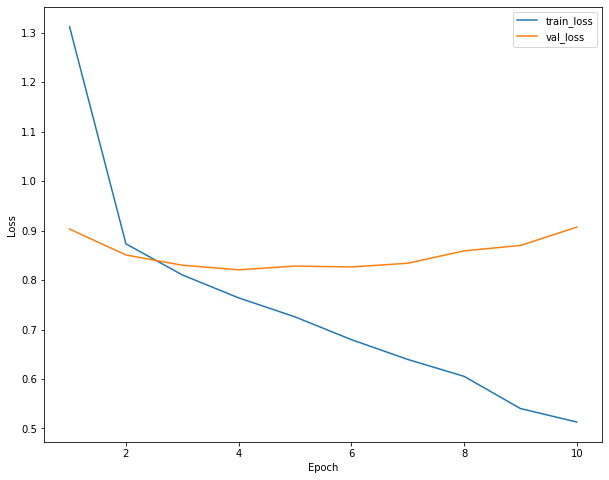

In [25]:
plt.figure(figsize=(10,8))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(df1['epoch'],df1['train_loss'],label='train_loss')
plt.plot(df1['epoch'],df1['validation_loss'],label='val_loss')
# plt.plot(loss_dic['epoch'],nolora_df['train_loss'],label='no_lora_trainloss')
# plt.plot(loss_dic['epoch'],nolora_df['validation_loss'],label='no_lora_valloss')

plt.legend()
plt.show()

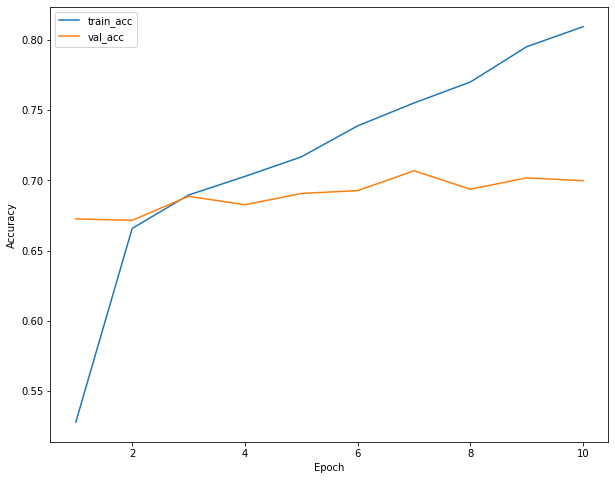

In [26]:
plt.figure(figsize=(10,8))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.plot(df1['epoch'],df1['train_acc'],label='train_acc')
plt.plot(df1['epoch'],df1['val_acc'],label='val_acc')
# plt.plot(loss_dic['epoch'],nolora_df['train_acc'],label='no_lora_train_acc')
# plt.plot(loss_dic['epoch'],nolora_df['val_acc'],label='no_lora_acc')
plt.legend()
plt.show()

## 오름차순의 추론


In [24]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(cfg.model_path)

for i in range(20) :
    save_path = f"/home/work/CL/final_healthmodel/lora_asc_{i+1}epoch.pt"
    model = torch.load(save_path)

    print(i+1,infer(model=model,loader=test_loader))



62it [00:08,  7.23it/s]


test_61_stepLoss:0.8800442699463137
test_61_stepacc:0.6703629032258065
1 (0.8800442699463137, 0.6703629032258065)


62it [00:08,  7.55it/s]


test_61_stepLoss:0.8117406272119091
test_61_stepacc:0.6945564516129032
2 (0.8117406272119091, 0.6945564516129032)


62it [00:08,  7.50it/s]


test_61_stepLoss:0.7861387003814021
test_61_stepacc:0.7056451612903226
3 (0.7861387003814021, 0.7056451612903226)


62it [00:08,  7.50it/s]


test_61_stepLoss:0.7775404664777941
test_61_stepacc:0.7096774193548387
4 (0.7775404664777941, 0.7096774193548387)


62it [00:08,  7.52it/s]


test_61_stepLoss:0.7710047378655402
test_61_stepacc:0.7268145161290323
5 (0.7710047378655402, 0.7268145161290323)


62it [00:08,  7.50it/s]


test_61_stepLoss:0.7672452215225466
test_61_stepacc:0.717741935483871
6 (0.7672452215225466, 0.717741935483871)


62it [00:08,  7.47it/s]


test_61_stepLoss:0.7706577955715118
test_61_stepacc:0.7116935483870968
7 (0.7706577955715118, 0.7116935483870968)


62it [00:08,  7.47it/s]


test_61_stepLoss:0.7894127111761801
test_61_stepacc:0.7046370967741935
8 (0.7894127111761801, 0.7046370967741935)


62it [00:08,  7.46it/s]


test_61_stepLoss:0.8042786222311759
test_61_stepacc:0.7106854838709677
9 (0.8042786222311759, 0.7106854838709677)


62it [00:08,  7.47it/s]


test_61_stepLoss:0.8184656286912579
test_61_stepacc:0.7147177419354839
10 (0.8184656286912579, 0.7147177419354839)


FileNotFoundError: [Errno 2] No such file or directory: '/home/work/CL/final_healthmodel/lora_asc_11epoch.pt'